In [26]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import ks_2samp, mannwhitneyu, wasserstein_distance, norm
from pathlib import Path
from datasets import load_dataset

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
# Set plotting style and fonts
sns.set_style('whitegrid')
# Increase font sizes for readability
sns.set_context('notebook', font_scale=1.4)
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

# MusicCaps Dataset vs ConceptCaps Tags Comparison

This notebook compares the original training dataset with ConceptCaps tags dataset to validate the generation quality and assess how well the VAE preserves the statistical properties of the original data.


## Load and Prepare Datasets


In [27]:
KNOWN_TAGS = json.load(open("../data/concepts_to_tags.json", "r"))

# Reverse map for easy lookup (tag -> category)
TAG_TO_CATEGORY = {}
for cat, tags in KNOWN_TAGS.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat

ALL_TAGS = set([tag for tags in KNOWN_TAGS.values() for tag in tags])

In [28]:
# Parse tags into categories
def parse_tags(tags):
    # filter out unknown tags
    tags = [t for t in tags if t in TAG_TO_CATEGORY]
    return pd.Series({
        'genre_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'genre'],
        'mood_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'mood'],
        'instrument_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'instrument'],
        'tempo_tags': [t for t in tags if TAG_TO_CATEGORY[t] == 'tempo']
    })

In [29]:
df_mc = load_dataset("google/MusicCaps", split="train").to_pandas()
df_mc['aspect_list'] = df_mc['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
tag_categories_mc = df_mc['aspect_list'].apply(parse_tags)
df_mc = pd.concat([df_mc, tag_categories_mc], axis=1)

print("\nMusicCaps Dataset Loaded")
print(f"  Shape: {df_mc.shape}")
print(f"  Sample row:")
print(df_mc.iloc[0])


MusicCaps Dataset Loaded
  Shape: (5521, 13)
  Sample row:
ytid                                                              -0Gj8-vB1q4
start_s                                                                    30
end_s                                                                      40
audioset_positive_labels                         /m/0140xf,/m/02cjck,/m/04rlf
aspect_list                 [low quality, sustained strings melody, soft f...
caption                     The low quality recording features a ballad so...
author_id                                                                   4
is_balanced_subset                                                      False
is_audioset_eval                                                         True
genre_tags                                                  [soulful, ballad]
mood_tags                                                               [sad]
instrument_tags                                                            []
temp

In [30]:

# Load ConceptCaps dataset
df_vae = pd.read_csv("../data/vae-tags-dataset/all.csv")
df_vae = df_vae.reset_index(drop=True)
df_vae = df_vae.fillna('')

# Parse tag strings and list representations
df_vae['aspect_list'] = df_vae['aspect_list'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['mood_tags'] = df_vae['mood_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['genre_tags'] = df_vae['genre_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['instrument_tags'] = df_vae['instrument_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
df_vae['tempo_tags'] = df_vae['tempo_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

print("\nConceptCaps Dataset Loaded")
print(f"  Shape: {df_vae.shape}")
print(f"  Unique temperatures: {df_vae['temperature'].unique()}")
print(f"  Sample row:")
print(df_vae.iloc[0])


ConceptCaps Dataset Loaded
  Shape: (23815, 8)
  Unique temperatures: [2.   1.   0.5  0.75 0.25 1.25 1.75 1.5 ]
  Sample row:
aspect_list               [acoustic guitar, pop, uptempo]
original_aspect_list    ['pop', 'funk', 'rock', 'guitar']
temperature                                           2.0
instrument_tags                         [acoustic guitar]
genre_tags                                          [pop]
mood_tags                                              []
tempo_tags                                      [uptempo]
id                       d59ad550f7f046fbc63513a684e30a87
Name: 0, dtype: object


In [31]:
# Load random tags dataset
df_random = pd.read_csv("../data/random-tags-dataset/all.csv")
df_random = df_random.reset_index(drop=True)
df_random = df_random.fillna('')

# Parse tag strings and list representations
df_random['aspect_list'] = df_random['aspect_list'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['mood_tags'] = df_random['mood_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['genre_tags'] = df_random['genre_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['instrument_tags'] = df_random['instrument_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_random['tempo_tags'] = df_random['tempo_tags'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

print("\nRandom Tags Dataset Loaded")
print(f"  Shape: {df_random.shape}")
print(f"  Sample row:")
print(df_random.iloc[0])


Random Tags Dataset Loaded
  Shape: (12000, 6)
  Sample row:
instrument_tags                                        [punchy kick]
mood_tags          [happy,  passionate,  scary,  eerie,  upliftin...
genre_tags                        [ambient sounds,  dance,  soulful]
tempo_tags                     [fast tempo,  uptempo,  dance groove]
aspect_list        [punchy kick,  happy,  passionate,  scary,  ee...
id                                                       sample_0000
Name: 0, dtype: object


In [32]:

# For easier comparison, focus on a single temperature (use 1.0 as baseline)
df_vae_baseline = df_vae[df_vae['temperature'] == 1.0].reset_index(drop=True)

print(f"\nUsing VAE dataset at temperature=1.0")
print(f"  Shape: {df_vae_baseline.shape}")


Using VAE dataset at temperature=1.0
  Shape: (4938, 8)


## Compute Tag Distribution Statistics


In [33]:

# Define tag categories for comparison
tag_categories = {
    'Tempo': 'tempo_tags',
    'Genre': 'genre_tags',
    'Mood': 'mood_tags',
    'Instrument': 'instrument_tags',
    'All Tags': 'aspect_list'
}

# Compute statistics for each category
stats_data = []

for cat_name, col in tag_categories.items():
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_baseline[col].apply(len)
    random_counts = df_random[col].apply(len)
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'MusicCaps',
        'Mean': train_counts.mean(),
        'Median': train_counts.median(),
        'Std': train_counts.std(),
        'Min': train_counts.min(),
        'Max': train_counts.max(),
        'Q25': train_counts.quantile(0.25),
        'Q75': train_counts.quantile(0.75),
        'Count': len(train_counts)
    })
    
    stats_data.append({
        'Category': cat_name,
        'Dataset': 'ConceptCaps',
        'Mean': vae_counts.mean(),
        'Median': vae_counts.median(),
        'Std': vae_counts.std(),
        'Min': vae_counts.min(),
        'Max': vae_counts.max(),
        'Q25': vae_counts.quantile(0.25),
        'Q75': vae_counts.quantile(0.75),
        'Count': len(vae_counts)
    })

    stats_data.append({
        'Category': cat_name,
        'Dataset': 'Random Tags',
        'Mean': random_counts.mean(),
        'Median': random_counts.median(),
        'Std': random_counts.std(),
        'Min': random_counts.min(),
        'Max': random_counts.max(),
        'Q25': random_counts.quantile(0.25),
        'Q75': random_counts.quantile(0.75),
        'Count': len(random_counts)
    })

stats_df = pd.DataFrame(stats_data)

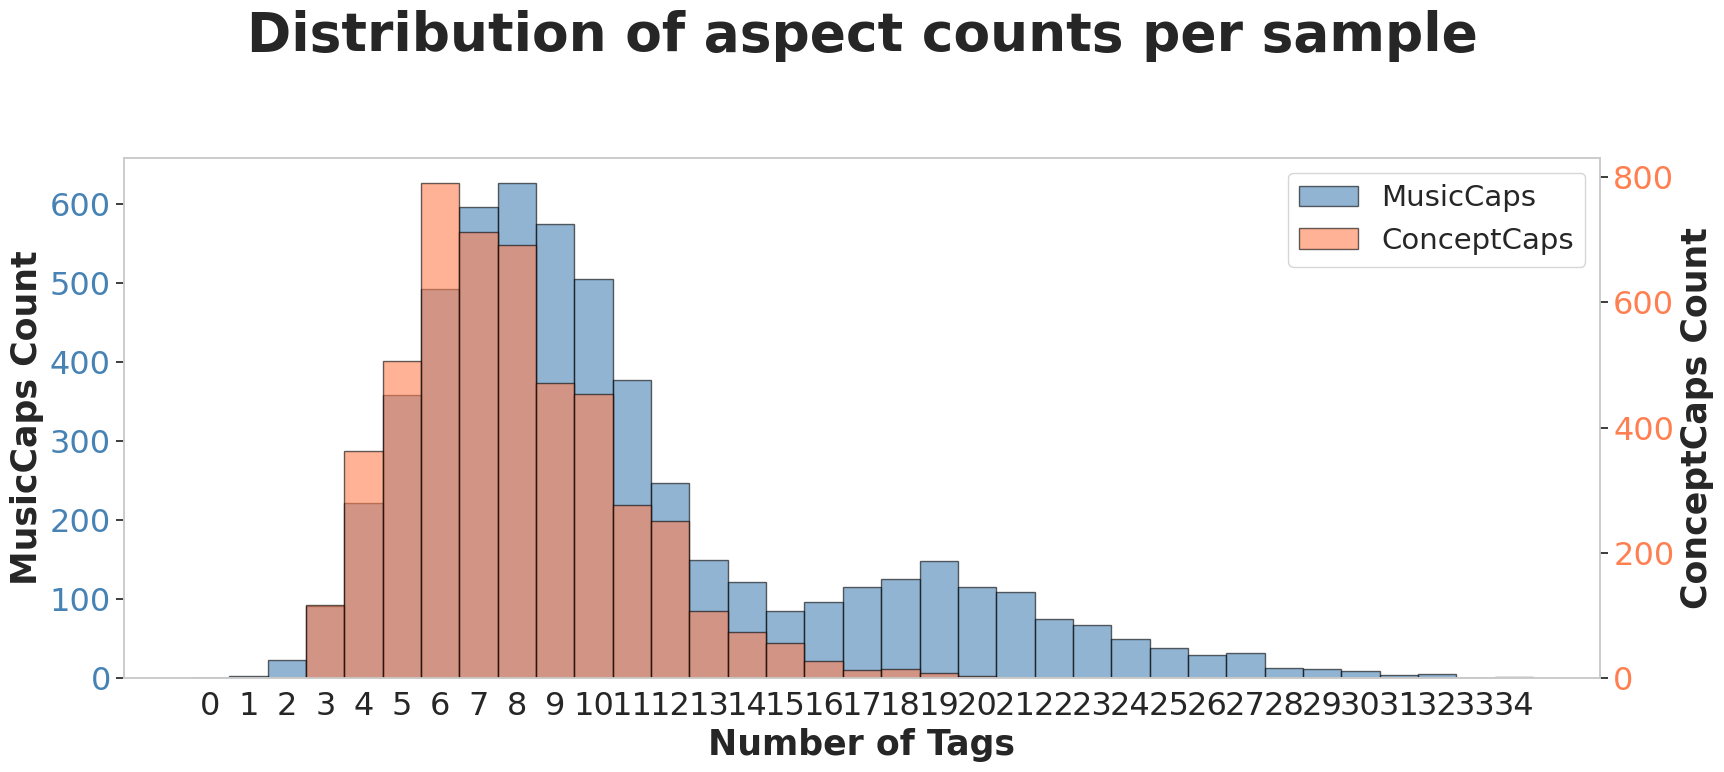

In [34]:
fig, ax = plt.subplots()
ax1 = ax
ax2 = ax.twinx()

train_counts = df_mc['aspect_list'].apply(len)
vae_counts = df_vae_baseline['aspect_list'].apply(len)

max_count = max(train_counts.max(), vae_counts.max())
bins = np.arange(0, max_count + 2)
bin_centers = (bins[:-1] + bins[1:]) / 2

n1, _, patches1 = ax1.hist(train_counts, bins=bins, alpha=0.6, label='MusicCaps', color='steelblue', edgecolor='black')
n2, _, patches2 = ax2.hist(vae_counts, bins=bins, alpha=0.6, label='ConceptCaps', color='coral', edgecolor='black')

ax1.set_xticks(bin_centers)
ax1.set_xticklabels([str(int(bc)) for bc in bin_centers])

ax1.set_xlabel('Number of Tags', fontweight='bold')
ax1.set_ylabel('MusicCaps Count', fontweight='bold')
ax2.set_ylabel('ConceptCaps Count', fontweight='bold')

ax1.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2

ax1.legend(handles, labels, loc='upper right')
ax1.grid(False)
ax2.grid(False)

plt.suptitle('Distribution of aspect counts per sample', fontweight='bold', y=1.0)
plt.tight_layout()
plt.savefig("../docs/assets/tag_count_distribution_comparison.pdf", bbox_inches='tight')
plt.show()

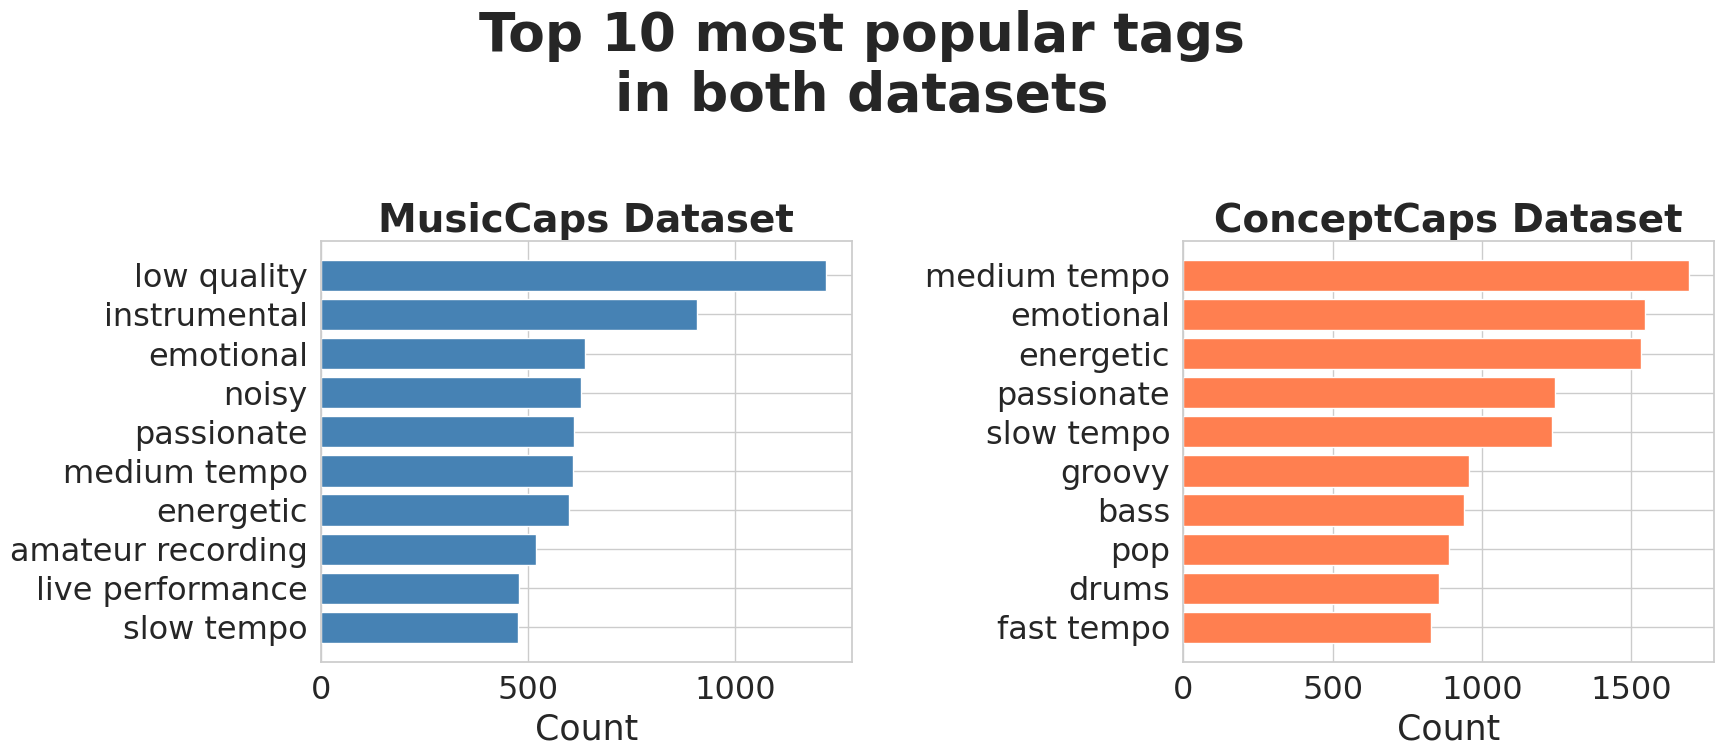

In [35]:
def get_top_tags(df, col, top_k=10):
    all_tags = [tag for tags in df[col] for tag in tags]
    tag_counts = Counter(all_tags)
    return tag_counts.most_common(top_k)
top_tags_mc = get_top_tags(df_mc, 'aspect_list')
top_tags_vae = get_top_tags(df_vae_baseline, 'aspect_list')
fig, axes = plt.subplots(1, 2)
axes[0].barh([tag for tag, _ in top_tags_mc][::-1], [count for _, count in top_tags_mc][::-1], color='steelblue')
axes[0].set_title('MusicCaps Dataset', fontweight='bold')
axes[0].set_xlabel('Count')
axes[1].barh([tag for tag, _ in top_tags_vae][::-1], [count for _, count in top_tags_vae][::-1], color='coral')
axes[1].set_title('ConceptCaps Dataset', fontweight='bold')
axes[1].set_xlabel('Count')
plt.suptitle("Top 10 most popular tags\nin both datasets", fontweight='bold')
plt.tight_layout()
plt.savefig("../docs/assets/top_10_tags_per_dataset.pdf", bbox_inches='tight')
plt.show()

## Compare Individual Tag Distributions

Analyze how specific tags (genre, instrument, mood) are distributed in each dataset to assess if VAE generation preserves individual tag frequencies.

In [36]:
# Flatten all tags and count occurrences
from collections import Counter

tag_type_comparisons = []

# Helper function to get all tags from a column
def get_all_tags(df, column):
    all_tags = []
    for tag_list in df[column]:
        all_tags.extend(tag_list)
    return all_tags

# Compare each tag category - using ALL temperatures in VAE dataset
categories_to_compare = [
    ('Genre', 'genre_tags'),
    ('Instrument', 'instrument_tags'),
    ('Mood', 'mood_tags'),
    ('Tempo', 'tempo_tags')
]

tag_comparison_results = {}

df_vae_all = df_vae.reset_index(drop=True)

for cat_name, col_name in categories_to_compare:
    train_tags = get_all_tags(df_mc, col_name)
    vae_tags = get_all_tags(df_vae_all, col_name)

    train_counter = Counter(train_tags)
    vae_counter = Counter(vae_tags)
    
    # Get all unique tags
    all_unique_tags = set(train_counter.keys()) | set(vae_counter.keys())
    
    # Create comparison dataframe with percentages
    comparison_data = []
    for tag in sorted(all_unique_tags):
        train_count = train_counter.get(tag, 0)
        vae_count = vae_counter.get(tag, 0)
        train_percentage = (train_count / len(train_tags) * 100) if len(train_tags) > 0 else 0
        vae_percentage = (vae_count / len(vae_tags) * 100) if len(vae_tags) > 0 else 0
        
        comparison_data.append({
            'Tag': tag,
            'MusicCaps Count': train_count,
            'VAE Count': vae_count,
            'MusicCaps %': train_percentage,
            'VAE %': vae_percentage,
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    tag_comparison_results[cat_name] = comparison_df

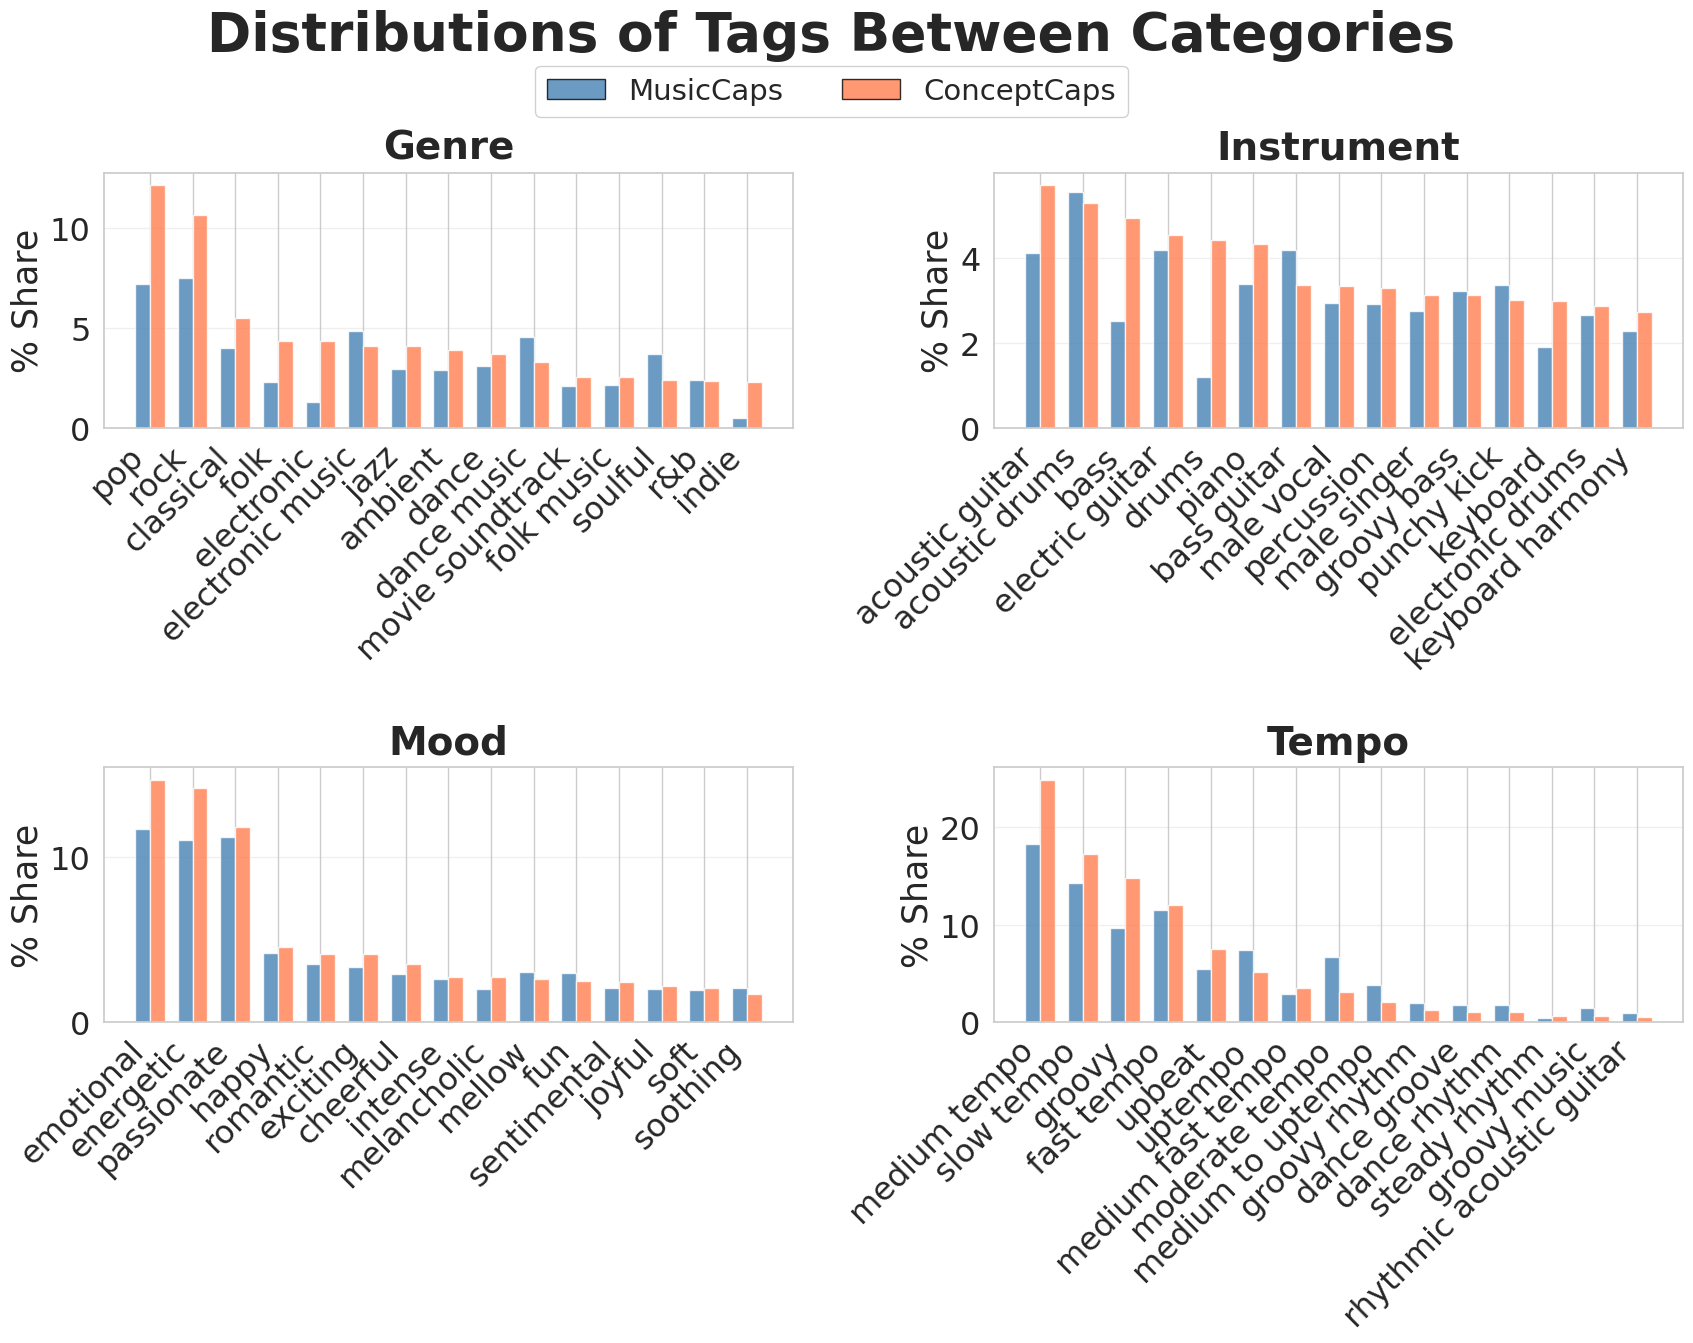

In [37]:
# Create visualizations comparing tag distributions
from matplotlib.patches import Patch


fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (cat_name, _) in enumerate(categories_to_compare):
    ax = axes[idx]
    comparison_df = tag_comparison_results[cat_name]
    
    top_tags = comparison_df.nlargest(15, 'VAE Count')
    
    x = np.arange(len(top_tags))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, top_tags['MusicCaps %'], width, label='MusicCaps', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, top_tags['VAE %'], width, label='ConceptCaps', color='coral', alpha=0.8)
    
    ax.set_ylabel('% Share')
    ax.set_title(f'{cat_name}', fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(top_tags['Tag'], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')

fig.suptitle('Distributions of Tags Between Categories', fontweight='bold', y=0.98)
legend_elems = [Patch(facecolor='steelblue', edgecolor='black', label='MusicCaps', alpha=0.8),
                Patch(facecolor='coral', edgecolor='black', label='ConceptCaps', alpha=0.8)]
fig.legend(handles=legend_elems, loc='upper center', ncol=2, framealpha=0.9, bbox_to_anchor=(0.5, 0.95))
plt.subplots_adjust(top=0.88, hspace=0.4)
plt.tight_layout()
plt.savefig("../docs/assets/tag_distribution_comparison.pdf", bbox_inches='tight')
plt.show()

## Compare Category-wise Tag Counts


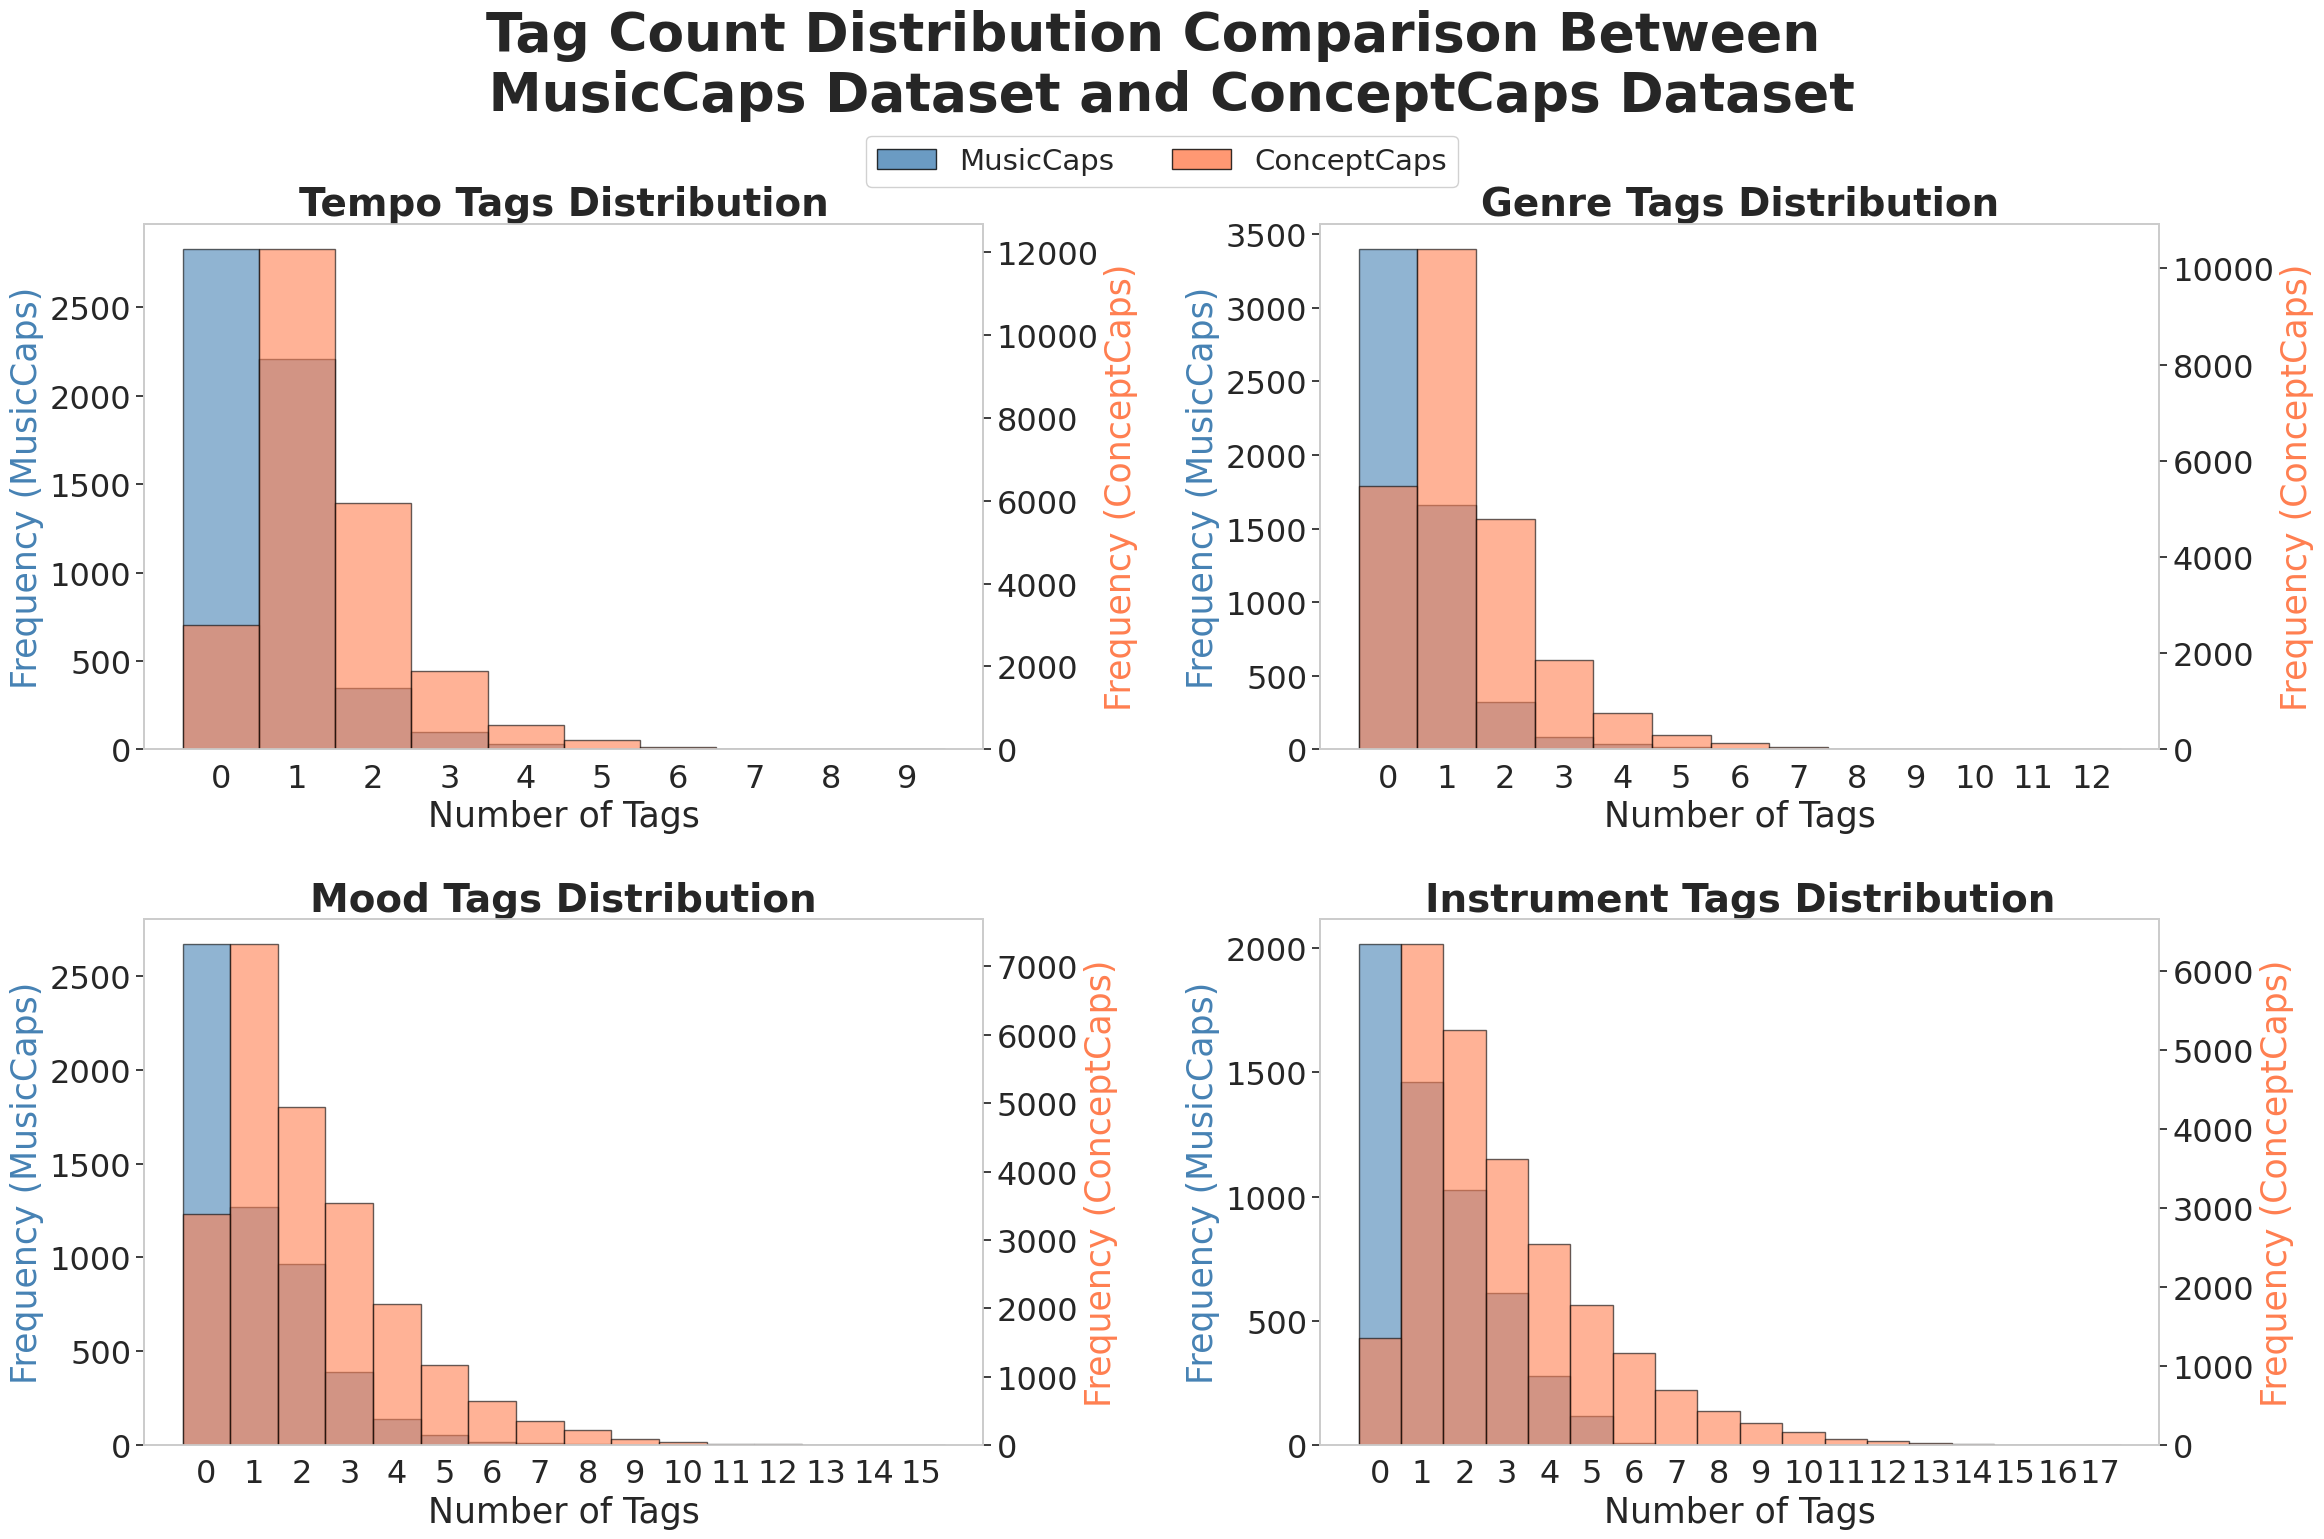

In [ ]:
_tag_categories = {
    'Tempo': 'tempo_tags',
    'Genre': 'genre_tags',
    'Mood': 'mood_tags',
    'Instrument': 'instrument_tags',
}
fig, axes = plt.subplots(2, len(_tag_categories) // 2, figsize=(24, 16))
axes = axes.flatten()

for idx, (cat_name, col) in enumerate(_tag_categories.items()):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    train_counts = df_mc[col].apply(len)
    vae_counts = df_vae_all[col].apply(len)
    
    # Create bins
    max_count = max(train_counts.max(), vae_counts.max())
    bins = np.arange(0, max_count + 2)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Plot histograms
    n1, _, patches1 = ax1.hist(train_counts, bins=bins, alpha=0.6, label='MusicCaps', color='steelblue', edgecolor='black')
    n2, _, patches2 = ax2.hist(vae_counts, bins=bins, alpha=0.6, label='ConceptCaps', color='coral', edgecolor='black')
    
    # Center x-axis labels to bars
    ax1.set_xticks(bin_centers)
    ax1.set_xticklabels([int(x) for x in bin_centers], rotation=0)
    
    ax1.set_xlabel('Number of Tags')
    ax1.set_ylabel('Frequency (MusicCaps)', color='steelblue')
    ax2.set_ylabel('Frequency (ConceptCaps)', color='coral')
    ax1.set_title(f'{cat_name} Tags Distribution', fontweight='bold')
    
    handles = [patches1[0], patches2[0]]
    labels = ['MusicCaps', 'ConceptCaps']

    ax1.grid(False)
    ax2.grid(False)

fig.suptitle('Tag Count Distribution Comparison Between \n MusicCaps Dataset and ConceptCaps Dataset', fontweight='bold')
legend_elems = [Patch(facecolor='steelblue', edgecolor='black', label='MusicCaps', alpha=0.8),
                Patch(facecolor='coral', edgecolor='black', label='ConceptCaps', alpha=0.8)]
fig.legend(handles=legend_elems, loc='upper center', ncol=2, framealpha=0.9, bbox_to_anchor=(0.5, 0.91))
plt.subplots_adjust(top=0.85, hspace=0.4, wspace=0.3)
plt.tight_layout()
plt.show()